In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from preprocessing_utils import *
import datetime

from scipy.spatial.distance import cdist

In [2]:
# Parameters
start="1998-01-01"
end="2007-12-31"

TRAIN_PATH = "../data/pickle/df_stations_all_nonzero_extended.pkl"

st = (import_dataframe(TRAIN_PATH)
    .pipe(drop_df_NaNs, series='Prec') # Drop NaNs
    .pipe(clip_time_period, start, end) # Clip data temporally 
)

In [3]:
def occurrence(df, series='Prec'):
    if df[series] == 0:
        return 0
    else:
        return 1
    
st['occurrence'] = st.apply(occurrence, axis=1)

In [4]:
def season(df):
    # Premonsoon: Apr-May
    if (df['month'] >= 4) and (df['month'] <= 5):
        return 'Premonsoon (AM)'
    # Monsoon: June-Jul-Aug-Sept
    elif (df['month'] >= 6) and (df['month'] <= 9):
        return 'Monsoon (JJAS)'
    # Postmonsoon: Oct-Nov-Dec
    elif (df['month'] >= 10) and (df['month'] <= 12):
        return 'Postmonsoon (OND)'
    # Winter: Jan-Feb-Mar
    elif (df['month'] >= 1) or (df['month'] <= 3):
        return 'Winter (JFM)'

In [5]:
st['bias'] = st['wrf_prcp'] - st['Prec']

st.set_index('Date', inplace=True)
st['year'] = st.index.year
st['month'] = st.index.month
st['season'] = st.apply(season, axis=1)

st.reset_index(inplace=True)

In [6]:
seasons = st['season'].unique()

In [30]:
st.groupby(['Station','month']).sum()[['Prec']].reset_index()

,Station,month,Prec
0,Arki,1,260.1
1,Arki,2,376.2
2,Arki,3,481.9
3,Arki,4,147.6
4,Arki,5,357.9
...,...,...,...
691,Theog,8,1749.0
692,Theog,9,773.0
693,Theog,10,322.0
694,Theog,11,59.0


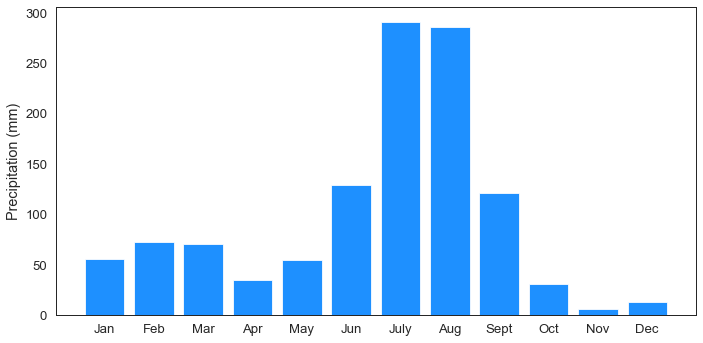

In [59]:
sns.set_theme(context='paper',style='white',font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,5))
x = np.arange(1,13)
y = st.groupby(['Station','month','year']).sum()[['Prec']].groupby('month').mean().values.squeeze()
plt.bar(x,y, color='dodgerblue')
ax.set_xticks(np.arange(1,13))
ax.set_ylabel('Precipitation (mm)')
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','July','Aug','Sept','Oct','Nov','Dec'])

# sns.boxplot(data = st.groupby(['Station','month','year']).sum()[['Prec']].reset_index(), x='month', y='Prec', color='dodgerblue')

plt.tight_layout()
plt.savefig(f'figures/monthly_precipitation', dpi=300)
plt.show()

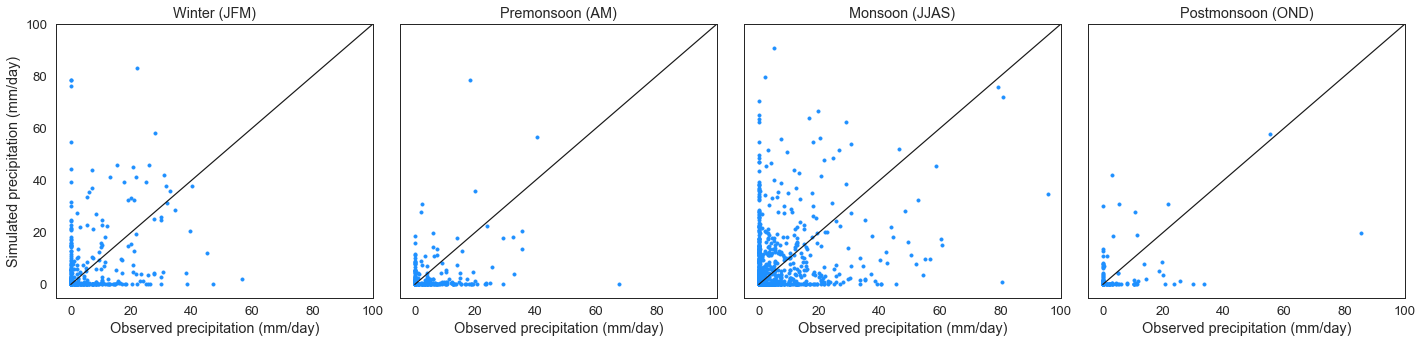

,Prec,wrf_prcp,bias
Prec,1.000000,0.492169,-0.664957
wrf_prcp,0.492169,1.000000,0.322889
bias,-0.664957,0.322889,1.000000


In [24]:
sns.set_theme(context='paper', style='white', font_scale=1.5)
fig, axes = plt.subplots(1,4, figsize=(20,5))

s = st['Station'].unique()[np.random.randint(len(st['Station'].unique()))]
s = 'Banjar'

for i, ax in enumerate(axes.flatten()):
    
    df = st[(st['season']==seasons[i]) & (st['Station']==s)].copy()

    x = df['Prec'].values
    y = df['wrf_prcp'].values

    z = max(max(x),max(y))

    ax.scatter(x,y,s=10,color='dodgerblue')
    ax.plot([0,1000],[0,1000],'k')
    ax.set_xlabel('Observed precipitation (mm/day)')
    ax.set_ylabel('Simulated precipitation (mm/day)') if i==0 else None
    
    ax.set_xlim(-5,100)
    ax.set_ylim(-5,100)
    
    ax.set_yticklabels([]) if i!=0 else None
    ax.set_title(f'{seasons[i]}')

plt.tight_layout()
plt.savefig(f'figures/seasonal-pairwise-correspondence-in-{s}', dpi=300)
plt.show()

df[['Prec','wrf_prcp','bias']].corr()

<ipython-input-736-4b7f318b8ee1>:41: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dapi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'figures/corr-sim-vs-obs.png', dapi=300)


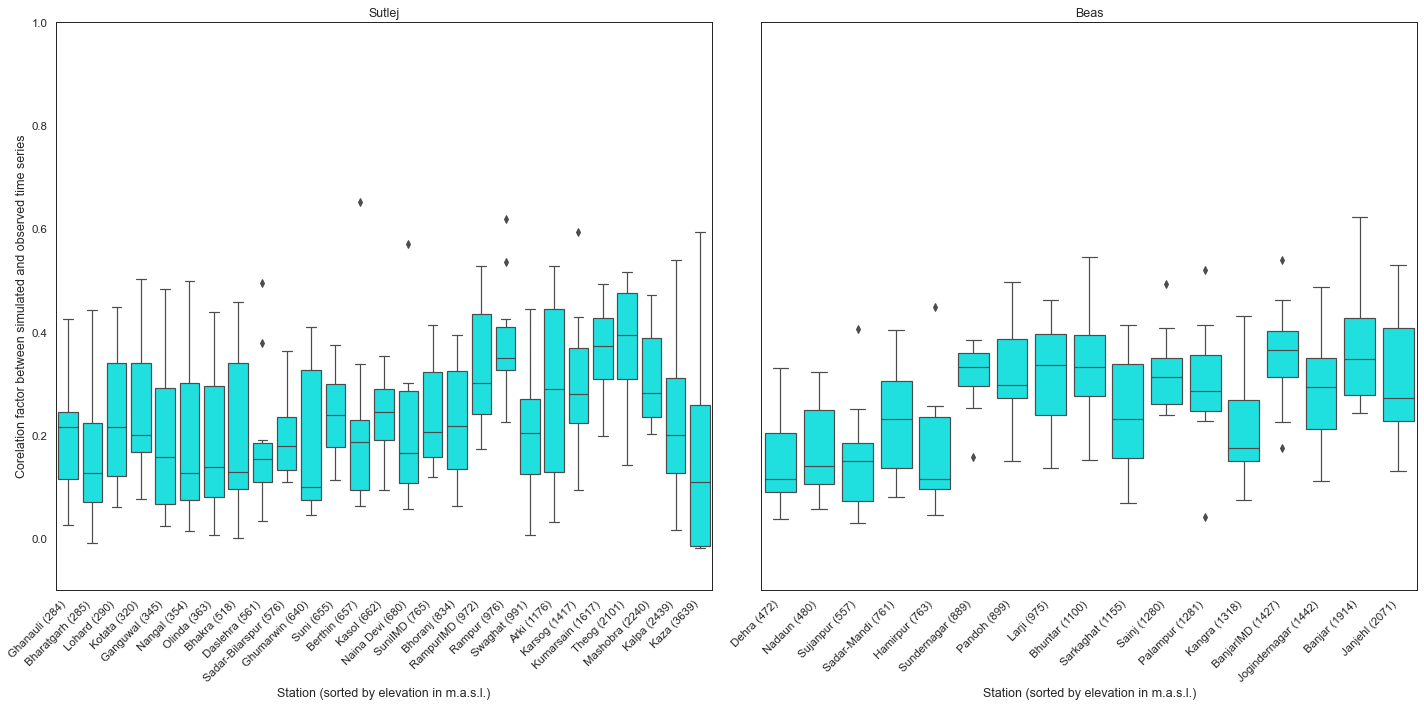

In [736]:
sns.set_theme(context="paper", style='white', font_scale=1.3)

basins= ['Sutlej','Beas']

fig, axes = plt.subplots(1,2,figsize=(20,10))

for index, ax in enumerate(axes.flatten()):
    
    basin = basins[index]
    
    st_basin = st[st['Basin']==basin]
    
    sorted_stations = st_basin.groupby(['Station']).mean().sort_values('Z').reset_index()['Station'].unique()
    sorted_elevations = [int(a) for a in st_basin.groupby(['Station']).mean().sort_values('Z').reset_index()['Z'].unique()]
    
    sorted_labels = [f'{b} ({a})' for a,b in zip(sorted_elevations,sorted_stations)]
    
    pw_corr = st[['Prec','wrf_prcp','Station','year','Z']].groupby(['Station','year','Z']).corr().reset_index()
    data = pw_corr[pw_corr['level_3']=='Prec'][['Station','year','wrf_prcp','Z']].dropna(axis=0).rename(columns={'wrf_prcp':'corr'})
    
    
    sns.boxplot(x="Z", y='corr', color='aqua', 
                   data=data, ax=ax, order=sorted_elevations)
    
    ax.set_xticklabels(sorted_labels,rotation=45, horizontalalignment='right')
    
    ax.set_title(basin)
    
    ax.set_ylim([-0.1,1])
    
    ax.set_xlabel('Station (sorted by elevation in m.a.s.l.)')
    
    if index == 0:
        ax.set_ylabel('Corelation factor between simulated and observed time series')
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        
plt.tight_layout()

plt.savefig(f'figures/corr-sim-vs-obs.png', dapi=300)
plt.show()

### Correlation plots

In [467]:
corr_series = ['bias']

st_pivot = st.pivot(index='Date',
        columns='Station',
        values=corr_series)

st_corr = st_pivot.corr(method='spearman')

In [468]:
# st_corr.reset_index(inplace=True)
# st_corr = st_corr[st_corr['level_0']=='Prec']['wrf_prcp'].copy()
# st_corr.set_index(st_corr.columns.values, inplace=True)

In [476]:
st_corr = st_corr.reset_index().set_index('Station').drop(columns=['level_0'])

/Users/marron31/miniconda3/envs/upperindus/lib/python3.8/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


array(['Arki', 'Banjar', 'BanjarIMD', 'Berthin', 'Bhakra', 'Bharatgarh',
       'Bharmaur', 'Bhoranj', 'Bhuntar', 'Churah', 'Dadahu', 'Daslehra',
       'Dehra', 'Dhaula Kuan', 'Ganguwal', 'Ghanauli', 'Ghumarwin',
       'Hamirpur', 'Janjehl', 'Jogindernagar', 'Jubbal', 'Kalatop',
       'Kalpa', 'Kandaghat', 'Kangra', 'Karsog', 'Kasol', 'Kaza',
       'Kotata', 'Kothai', 'Kumarsain', 'Larji', 'Lohard', 'Mashobra',
       'Nadaun', 'Nahan', 'Naina Devi', 'Nangal', 'Olinda', 'Pachhad',
       'Palampur', 'Pandoh', 'Paonta Sahib', 'Rakuna', 'Rampur',
       'RampurIMD', 'Rohru', 'Sadar-Bilarspur', 'Sadar-Mandi', 'Sainj',
       'Salooni', 'Sarkaghat', 'Sujanpur', 'Sundernagar', 'Suni',
       'SuniIMD', 'Swaghat', 'Theog'], dtype=object)

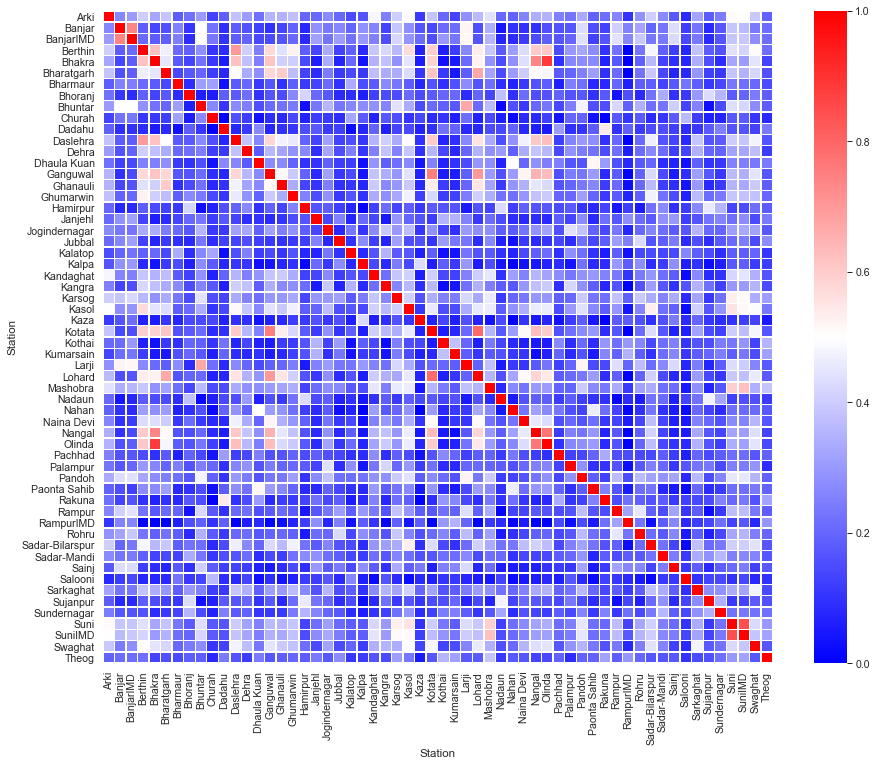

In [493]:
sns.set_theme(context='paper', style='white', font_scale=1.2)

fig, ax = plt.subplots(figsize=(15,12))

sns.heatmap(st_corr,
            ax=ax,
            #annot=True,
            linewidths=0.4,
            cmap='bwr', 
            #annot_kws={'size': 10},
            vmin=0,vmax=1,
            xticklabels=st_corr.index.values)

plt.xticks(rotation=90);
plt.yticks(rotation=0);

plt.xlabel('Station')

# plt.savefig(f'figures/corr-heatmap-{corr_series}.png')

plt.show()

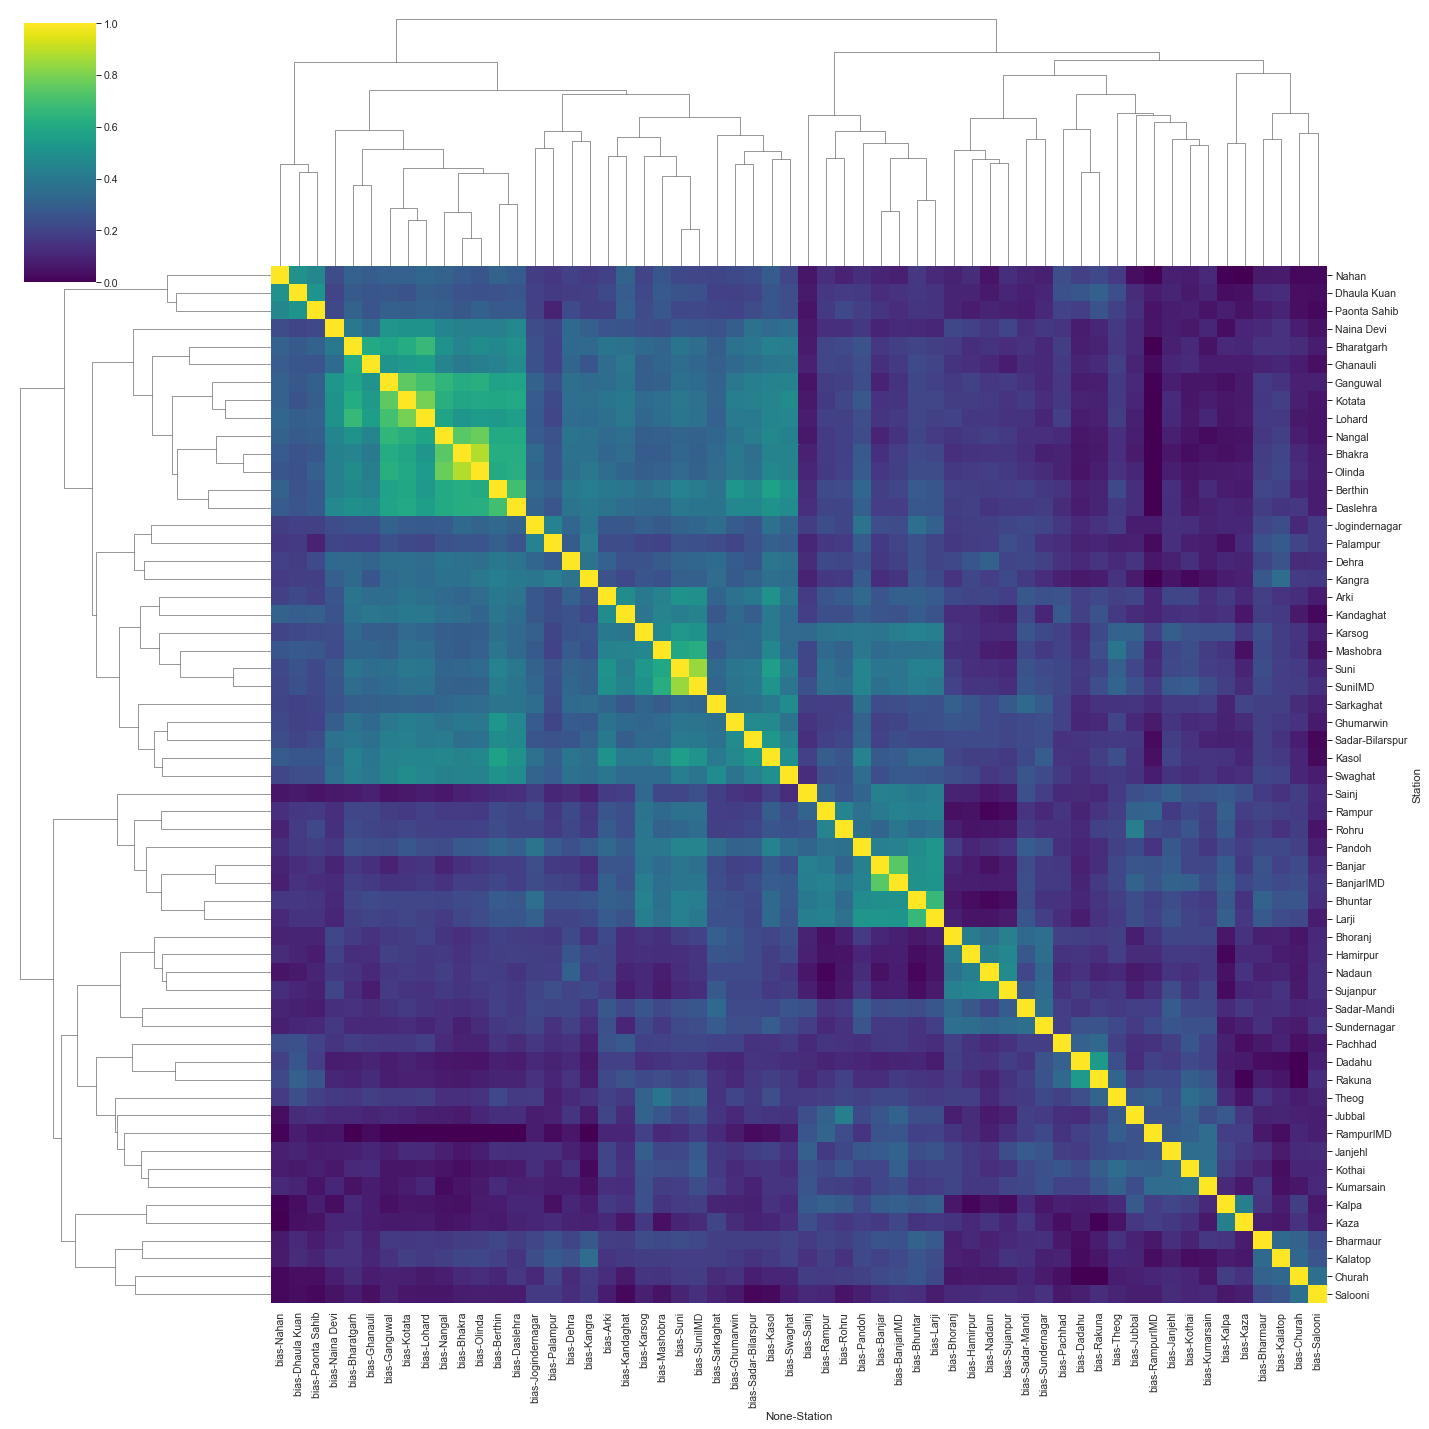

In [485]:
fig = sns.clustermap(st_corr,
               row_cluster=True,
               col_cluster=True,
               figsize=(20, 20),
               cmap='viridis',
               vmin=0,vmax=1,center=0.5
                    );
# plt.savefig(f'figures/corr-heatmap-clustered-{corr_series}.png',dpi=300)
plt.show()

In [494]:
def build_corr_df(st, dist_list=['Y','X'], corr_series='Prec'):
    
    st_pivot = st.pivot(index='Date',
        columns='Station',
        values=corr_series)

    st_corr = st_pivot.corr(method='spearman')
    
    st_coords = st.groupby(by=['Station']).mean()[dist_list]

    st_dist = pd.DataFrame(cdist(st_coords, st_coords, 'euclid'),index=st_coords.index,columns=st_coords.index)

    st_dist = st_dist.reset_index()
    st_dist = st_dist.rename(columns={'Station':'S1'})
    st_dist = st_dist.melt(id_vars=['S1'],value_name='dist').rename(columns={'Station':'S2'})

    st_dist_corr = st_corr.reset_index()
    st_dist_corr = st_dist_corr.rename(columns={'Station':'S1'})
    st_dist_corr = st_dist_corr.melt(id_vars='S1',value_name='corr').rename(columns={'Station':'S2'})

    df = st_dist.merge(st_dist_corr, on=['S1','S2'])

    st_basin = st.groupby(['Station','Basin']).mean().reset_index()[['Station','Basin']]

    df = df.merge(st_basin, left_on='S1', right_on='Station').rename(columns={'Basin':'B1'}).merge(st_basin, left_on='S2', right_on='Station').rename(columns={'Basin':'B2'})

    mask_basin = df['B1'] == df['B2'] # mask out corr between different basins
    mask_station = df['S1'] != df['S2'] # mask out autocorrelations (same station)
    
    mask = mask_basin & mask_station
    
    return df, mask

In [594]:
dist_list = ['Z']

def plot_corr(st, corr_series, dist_list, show_reg_line=True, save_to_file=False, show=True):

    df, mask = build_corr_df(st, dist_list=dist_list, corr_series=corr_series)
    fig,axes = plt.subplots(1,2,figsize=(20,8))
    x_lim = []

    for index, ax in enumerate(axes.flatten()):
        b = df[mask]['B1'].unique()[index]
        x = df['dist'][mask][df['B1']==b]
        y = df['corr'][mask][df['B1']==b]
        ax.plot(x,y,'o',markersize=5)
        ax.set_title(b)
        ax.set_xlabel(f'{",".join(dist_list)} distance (m)')
        ax.set_ylabel('Correlation factor') if index ==0 else None
        ax.set_yticklabels([]) if index>0 else None
        x_lim.append(x.max())

        if show_reg_line:
            m, n = np.polyfit(x, y, 1) # m = slope, b=intercept
            ax.plot(x, m*x + n, 'r')

    for ax in axes.flatten():
        ax.set_xlim([0, np.max(x_lim)])
        ax.set_ylim([0,1])
        ax.grid()
    
    plt.tight_layout()
    
    if save_to_file:
        plt.savefig(f'figures/corr-by-dist{"".join(dist_list)}-{corr_series}.png',dpi=300)    
    if show:
        plt.show()

In [592]:
def plot_seasonal_corr(st, corr_series, dist_list, show_reg_line=True, save_to_file=False, show=True):
    
    fig,axes = plt.subplots(2,4,figsize=(20,10))
    x_lim = []

    seasons = st['season'].unique()

    for index, ax in enumerate(axes.flatten()):

        if index < 4:
            j=0
            s = seasons[index]
        else:
            j=1
            s = seasons[index-4]

        df_input = st[st['season']==s]

        df, mask = build_corr_df(df_input, dist_list=dist_list, corr_series=corr_series)
        df.dropna(inplace=True)

        b = df[mask]['B1'].unique()[j]

        x = df['dist'][mask][df['B1']==b]
        y = df['corr'][mask][df['B1']==b]

        ax.plot(x,y,'o',markersize=3)

        ax.set_title(f"{s} in {b}")
        (ax.set_xlabel(f'{",".join(dist_list)} distance (m)')) if index >= 4 else None
        ax.set_ylabel(f'Correlation factor') if ((index == 0) or (index==4)) else None
        ax.set_xticklabels([]) if index < 4 else None
        ax.set_yticklabels([]) if (index % 4 != 0) else None

        x_lim.append(x.max())

        if show_reg_line:
            m, n = np.polyfit(x, y, 1) # m = slope, b=intercept
            ax.plot(x, m*x + n, 'r')

    for ax in axes.flatten():
        ax.set_xlim([0, np.max(x_lim)])
        ax.set_ylim([-0.2,1])
        ax.grid()
        
    plt.tight_layout()

    if save_to_file:
        plt.savefig(f'figures/seasonal-corr-by-dist{"".join(dist_list)}-{corr_series}.png',dpi=300)
    if show:
        plt.show()

occurrence-['X', 'Y']
Prec-['X', 'Y']
bias-['X', 'Y']
occurrence-['Z']
Prec-['Z']
bias-['Z']


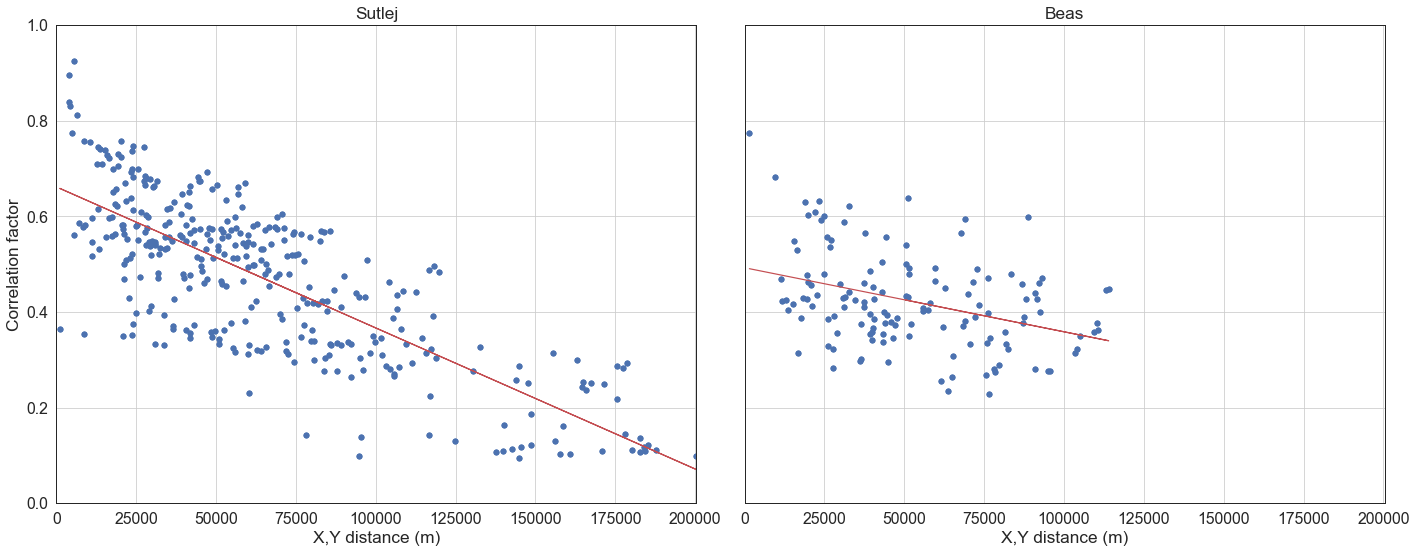

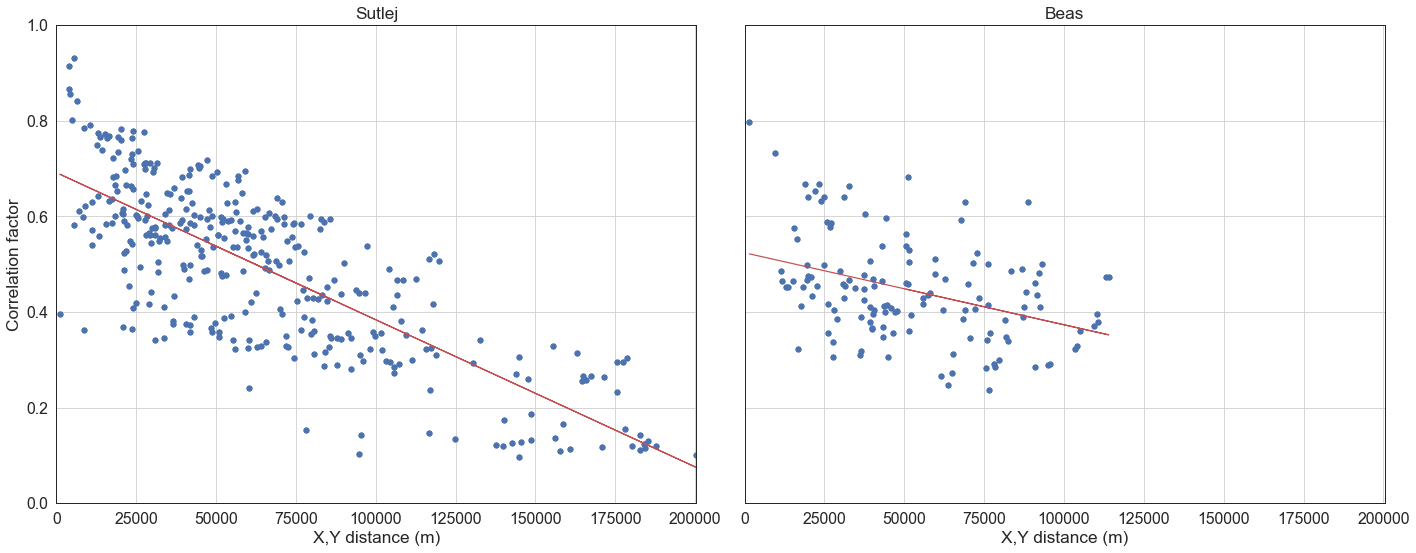

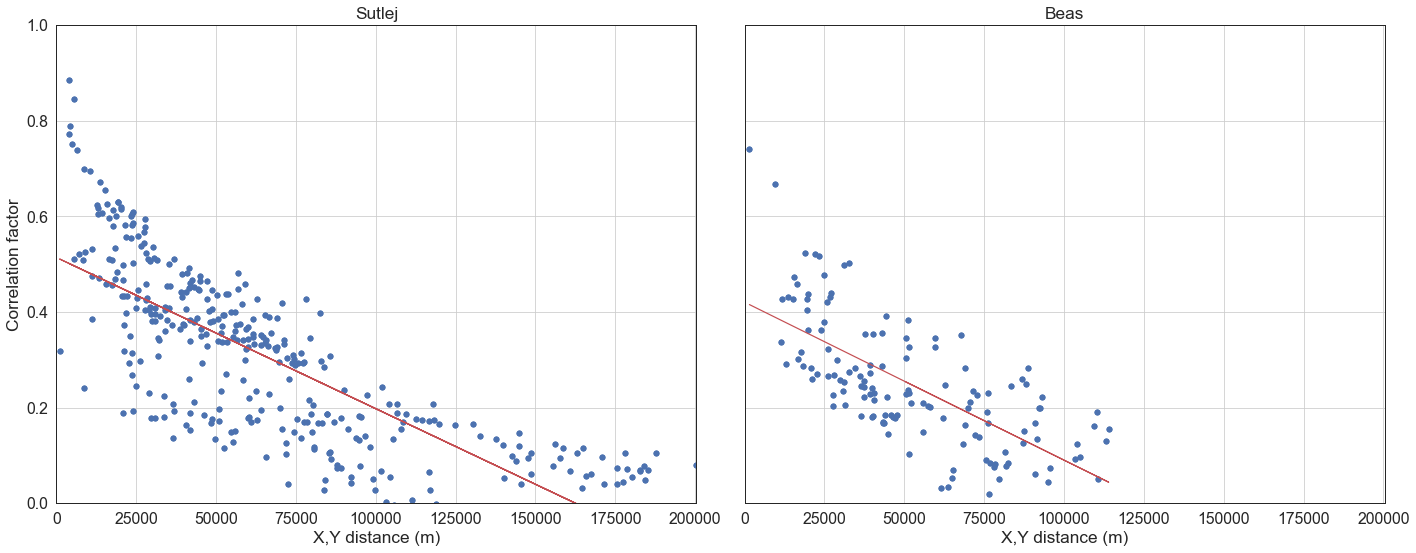

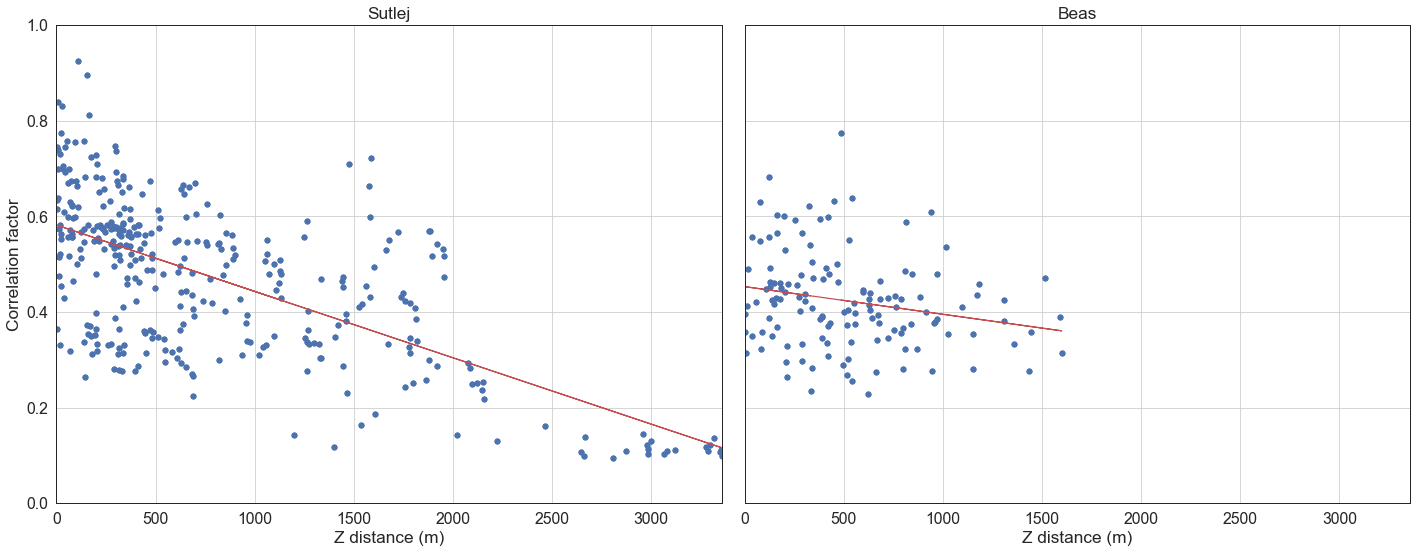

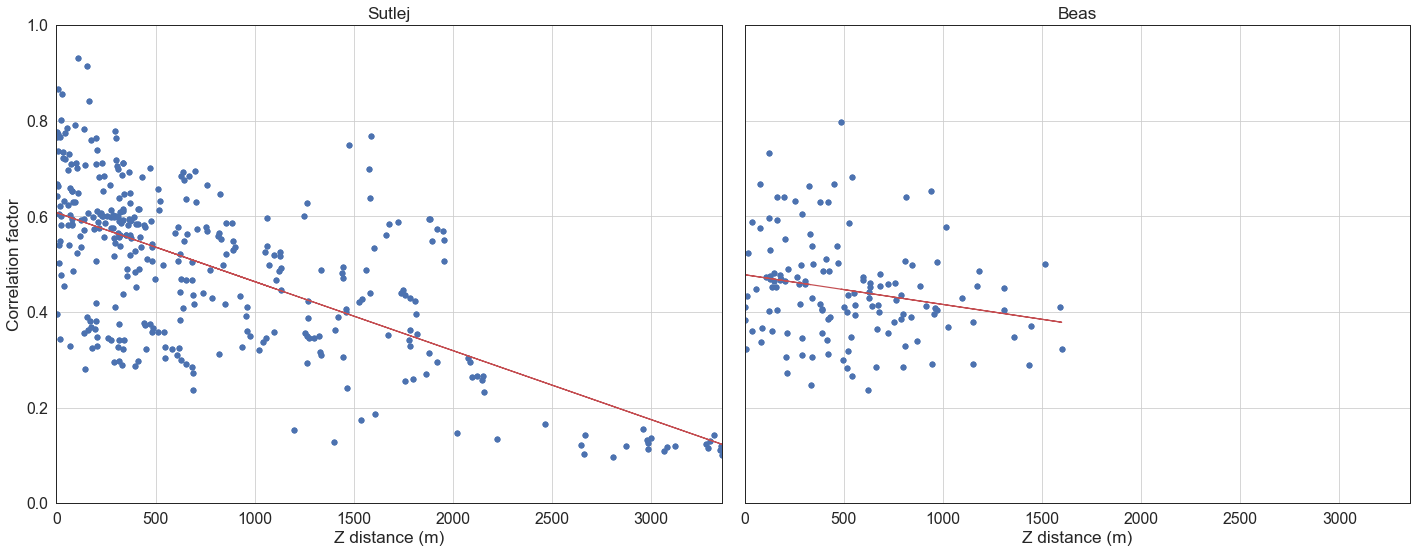

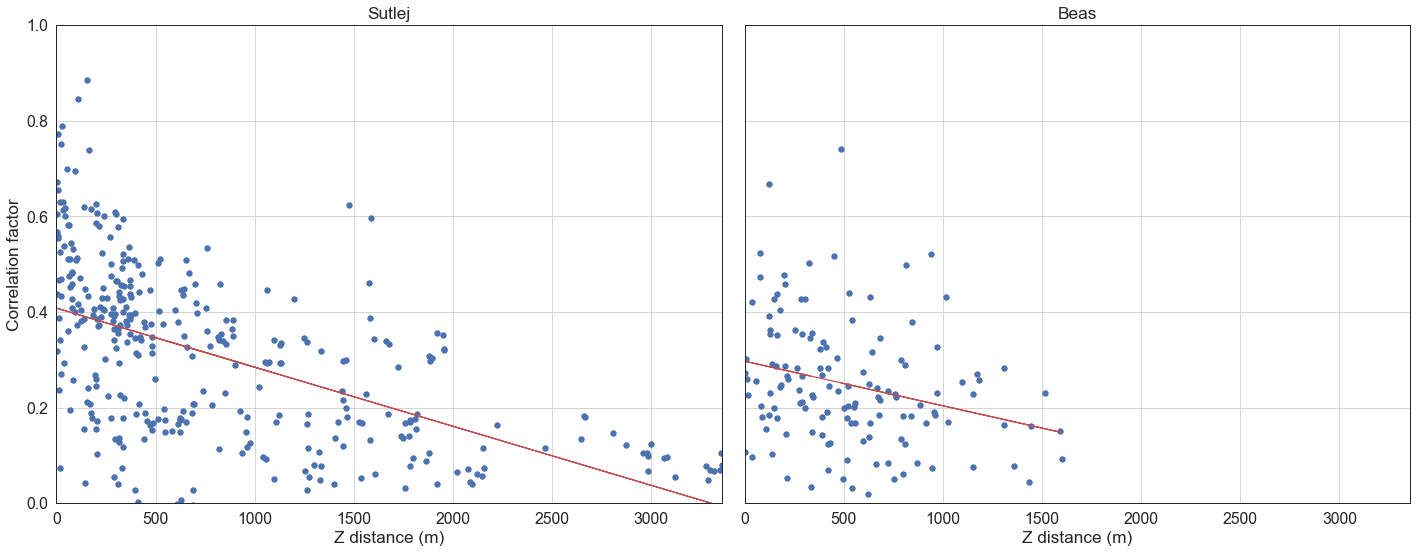

In [595]:
sns.set_theme(context='paper', style='white', font_scale=1.8)

dist_lists = [['X','Y'],['Z']]
corr_series_list = ['occurrence', 'Prec', 'bias']
show_reg_line = True

for dist_list in dist_lists:
    for corr_series in corr_series_list:
        plot_corr(st, corr_series, dist_list, show_reg_line=True, save_to_file=True, show=False)
#         plot_seasonal_corr(st, corr_series, dist_list, show_reg_line=True, save_to_file=True, show=False)
        print(f'{corr_series}-{dist_list}')

### Number of rain days per year

In [61]:
def aspect_categories(df):
    if (df['aspect']>315) or (df['aspect']<=45):
        return 'North'
    elif (df['aspect']>45) and (df['aspect']<=135):
        return 'East'
    elif (df['aspect']>135) and (df['aspect']<=225):
        return 'South'
    elif (df['aspect']>225) and (df['aspect']<=315):
        return 'West'
    
st['aspect_cat'] = st.apply(aspect_categories, axis=1)

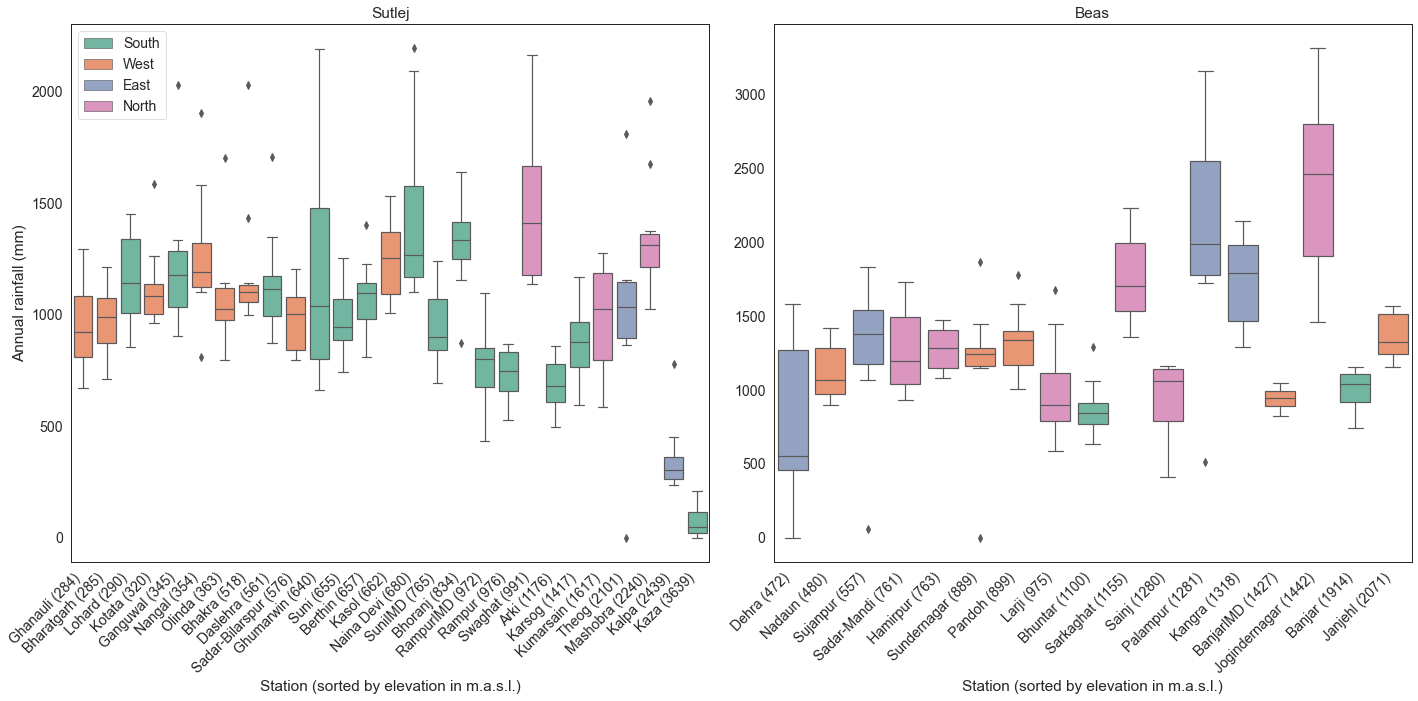

In [62]:
sns.set_theme(context='paper', style='white', font_scale=1.6)

basins= ['Sutlej','Beas']
series='Prec'

fig, axes = plt.subplots(1,2,figsize=(20,10))

for index, ax in enumerate(axes.flatten()):
    
    basin = basins[index]
    
    st_basin = st[st['Basin']==basin]
    
    sorted_stations = st_basin.groupby(['Station']).mean().sort_values('Z').reset_index()['Station'].unique()
    sorted_elevations = [int(a) for a in st_basin.groupby(['Station']).mean().sort_values('Z').reset_index()['Z'].unique()]
    
    sorted_labels = [f'{b} ({a})' for a,b in zip(sorted_elevations,sorted_stations)]
    
    data = st_basin.groupby(["year","Station","aspect_cat"]).agg({series:'sum', 'Z':'mean'}).reset_index()
    
#     ax.plot(data['Z'],data['occurrence'],'o')
    
#     data.boxplot(column='occurrence', by=['Z'], ax=ax, positions=sorted_elevations)
    
#     ax.set_xscale('log')
    
    sns.boxplot(x="Z", y=series, hue='aspect_cat', palette='Set2', dodge=False,
                   data=data, ax=ax, order=sorted_elevations)
    
    ax.set_xticklabels(sorted_labels,rotation=45, horizontalalignment='right')
    
    ax.set_title(basin)
    
    ax.set_xlabel('Station (sorted by elevation in m.a.s.l.)')
    
    if index == 0:
        if series == 'occurrence':
            ax.set_ylabel('Number of non-zero precipitation days per year')
        elif series == 'Prec':
            ax.set_ylabel('Annual rainfall (mm)')
        
        leg = ax.get_legend()
        leg.set_title('')
        
    else:
        ax.set_ylabel('')
        ax.get_legend().remove()
            
    
plt.tight_layout()    
    
plt.savefig(f'figures/annual-{series}-by-elevation.png', dpi=300)
    
plt.show()

### Timeseries

In [2]:
# df_station['year'] = df_station.index.year
# df_station['month'] = df_station.index.month
# df_station['season'] = df_station.apply(season, axis=1)
# df_station['logPrec'] = df_station['Prec'].transform(lambda x: np.log(x + 0.001))

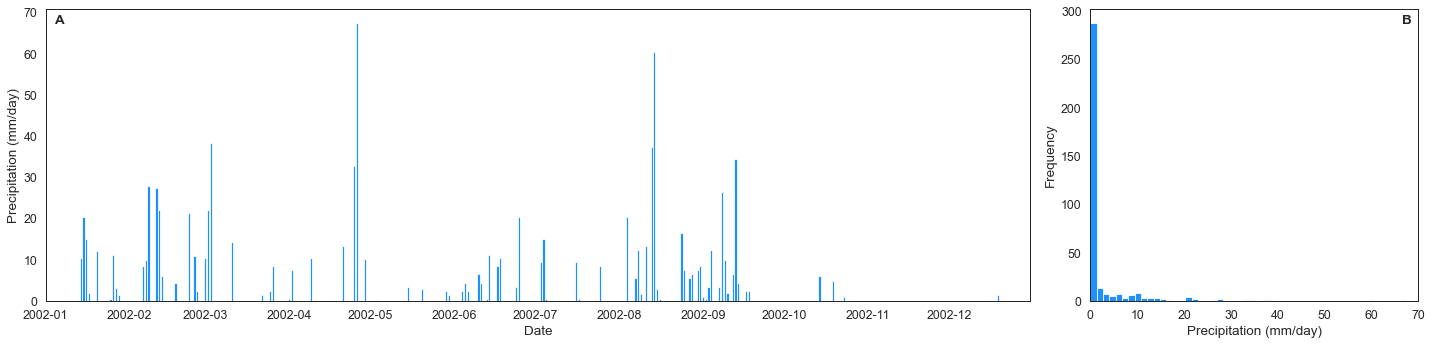

In [9]:
station = st['Station'].unique()[1]
df_station = st[st['Station']==station]
df_station.set_index('Date', inplace=True)

sns.set_theme(context='paper', style='white', font_scale=1.4)

start = '2002-01-01'
end = '2002-12-31'
data = df_station.loc[start:end]
data.reset_index(inplace=True)

fig, axes = plt.subplots(1,2,figsize=(20,5), gridspec_kw={'width_ratios': [3, 1]})

ax1, ax2 = axes.flatten()

ax1.bar(data['Date'], data['Prec'],color='dodgerblue')

ax1.set_xlim([datetime.datetime.strptime(start, "%Y-%m-%d"),datetime.datetime.strptime(end, "%Y-%m-%d")])
ax1.set_ylabel('Precipitation (mm/day)')
ax1.set_xlabel('Date')

ax2.hist(data['Prec'], bins=50, color='dodgerblue')
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Precipitation (mm/day)')
ax2.set_xlim(-0.10,70)

ax1.text(0.01, 0.95, "A", fontweight="bold", transform=ax1.transAxes)
ax2.text(0.95, 0.95, "B", fontweight="bold", transform=ax2.transAxes)

plt.tight_layout()
plt.savefig(f'figures/time-series-{station}_{start}_{end}.png',dpi=300) 
plt.show()

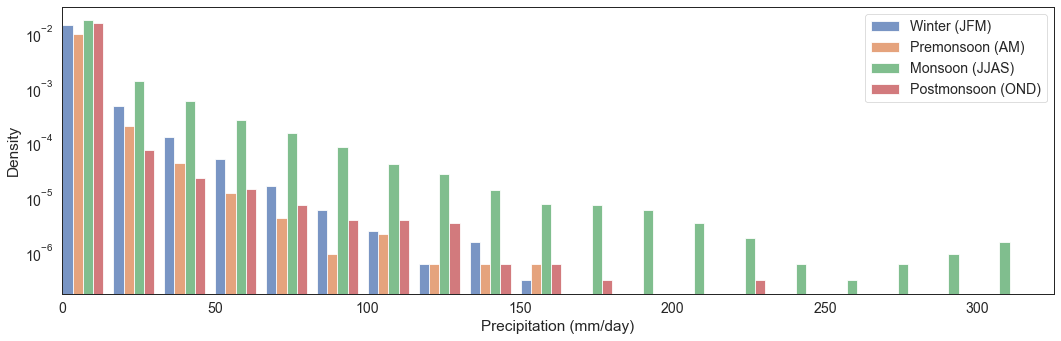

In [66]:
fig,ax = plt.subplots(figsize=(15,5))

sns.histplot(data=st,x='Prec',hue='season',multiple="dodge", stat='density', shrink=.8, ax=ax)
ax.set_xlim(0,325)
ax.set_yscale('log')
# ax.set_ylabel('Frequency
ax.set_xlabel('Precipitation (mm/day)')
leg = ax.get_legend()
leg.set_title('')
plt.tight_layout()
plt.savefig('figures/seasonal-histograms-logscale.png',dpi=300)
plt.show()

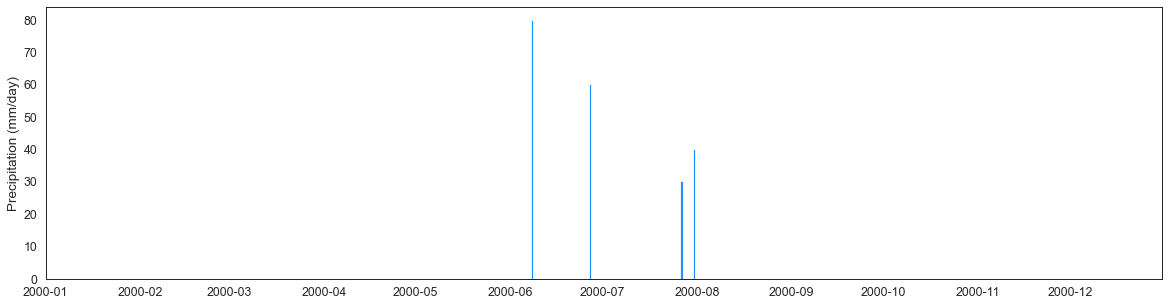

In [571]:
station = 'Kaza'
df_station = st[st['Station']==station]
df_station.set_index('Date', inplace=True)

start = '2000-01-01'
end = '2000-12-31'
data = df_station.loc[start:end]
data.reset_index(inplace=True)

fig = plt.subplots(figsize=(20,5))
plt.bar(data['Date'], data['Prec'],color='dodgerblue')

plt.xlim([datetime.datetime.strptime(start, "%Y-%m-%d"),datetime.datetime.strptime(end, "%Y-%m-%d")])
plt.ylabel('Precipitation (mm/day)')

# plt.savefig('figures/time-series.png',dpi=300) 
plt.show()

### ECDF

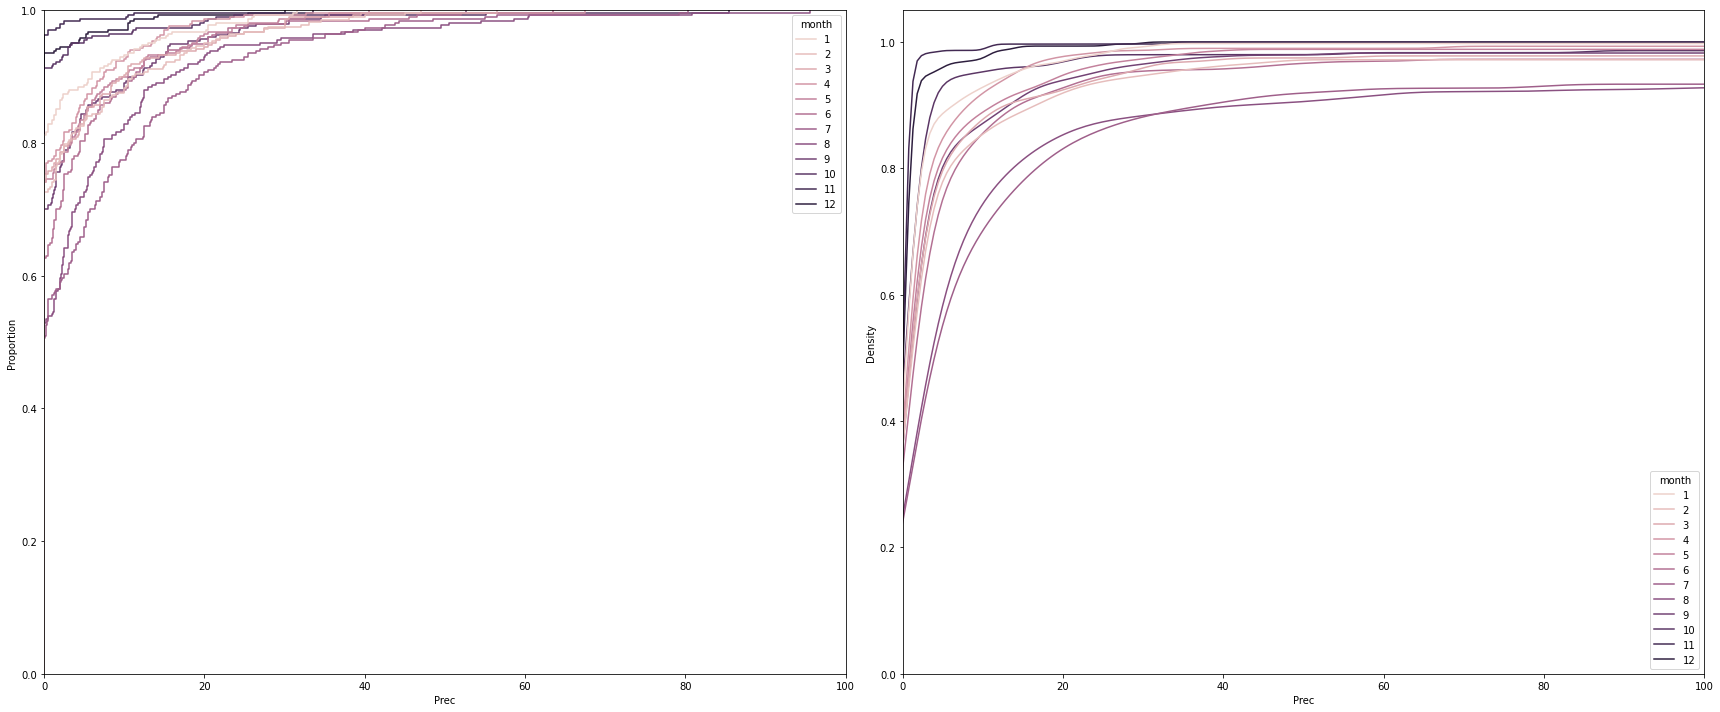

In [735]:
fig, axes = plt.subplots(1,2,figsize=(24,10))

ax = axes[0]
sns.ecdfplot(data=df_station, x='Prec', hue='month', ax=ax)

ax.set_xlim(0,100)

ax = axes[1]
sns.kdeplot(
    data=df_station, x="Prec", 
    hue="month",
    cumulative=True, common_norm=False, common_grid=True, ax=ax)

ax.set_xlim(0,100)

plt.tight_layout()
plt.show()

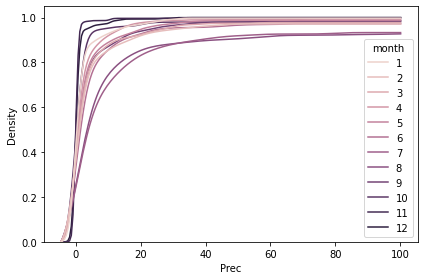

In [738]:
sns.kdeplot(
    data=df_station, x="Prec", 
    hue="month",
    cumulative=True, common_norm=False, common_grid=True,
)

plt.tight_layout()
plt.show()

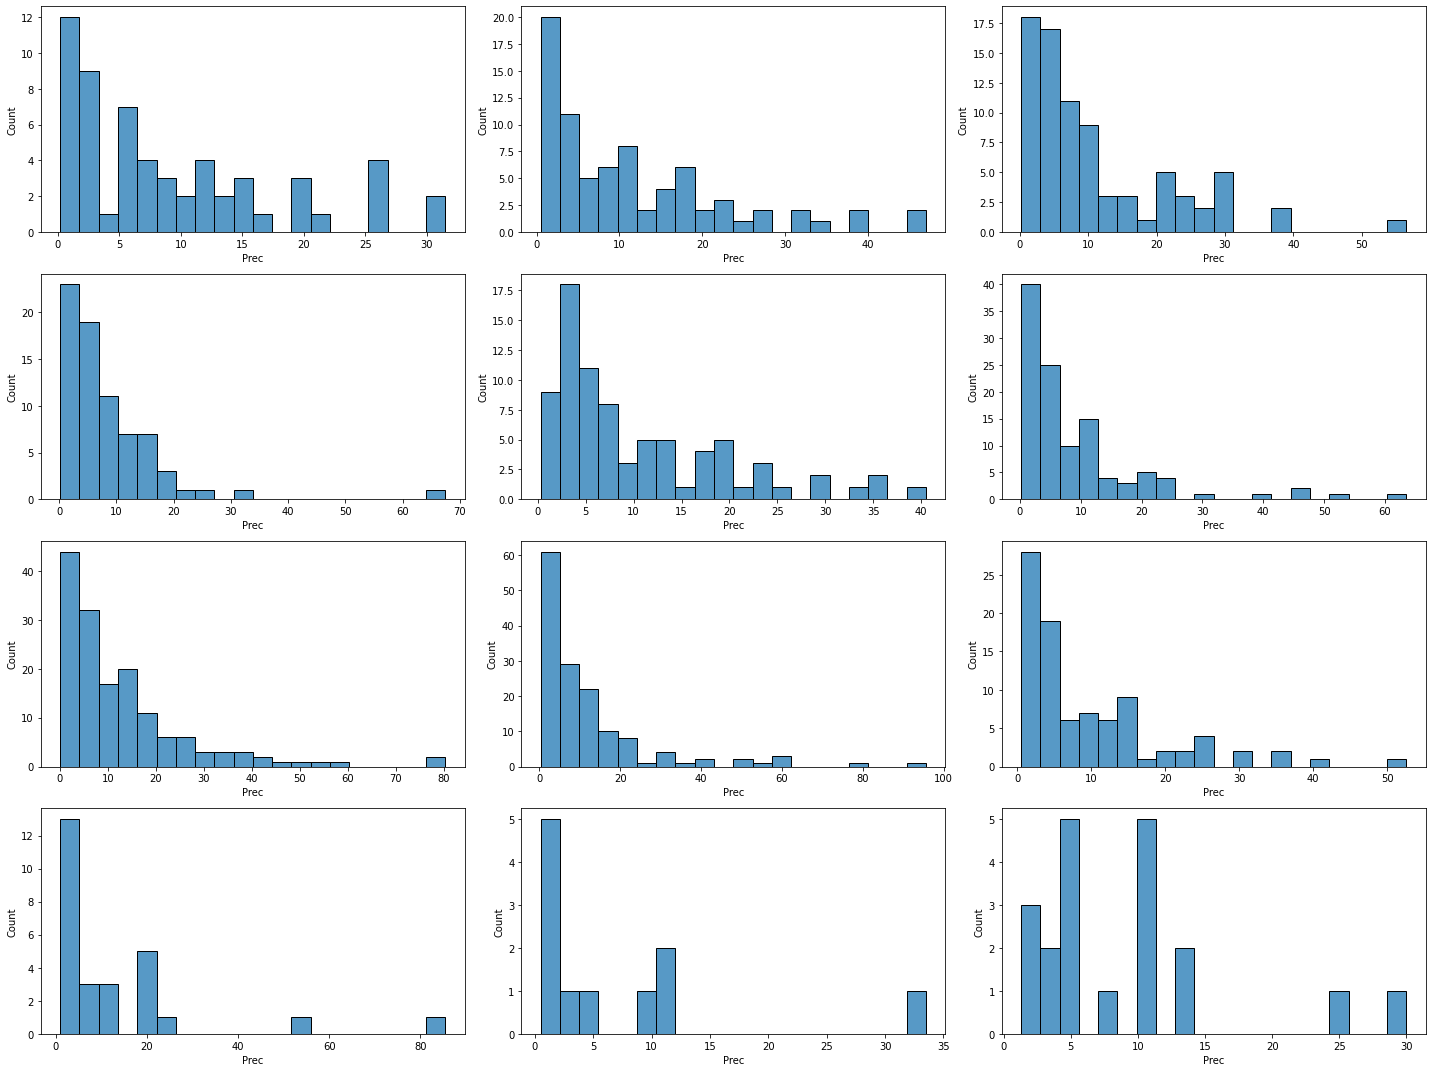

In [761]:
fig, axes = plt.subplots(4,3,figsize=(20,15))
for m, ax in enumerate(axes.flatten()):
    df2 = df_station[df_station['month']==m+1] 
    df2 = df2[df2['Prec']!=0]
    if len(df2)>0:
        #sns.ecdfplot(data=df2, x="Prec", hue='year', ax=ax)
        sns.histplot(data=df2, x="Prec", ax=ax, bins=20)
        #ax.ylim(0.6,1)
        #ax.hist(x, bins=100, cumulative=True, density=True, histtype='step')
        #plt.xlim(0,data['Prec'].max())

plt.tight_layout()        
plt.show()

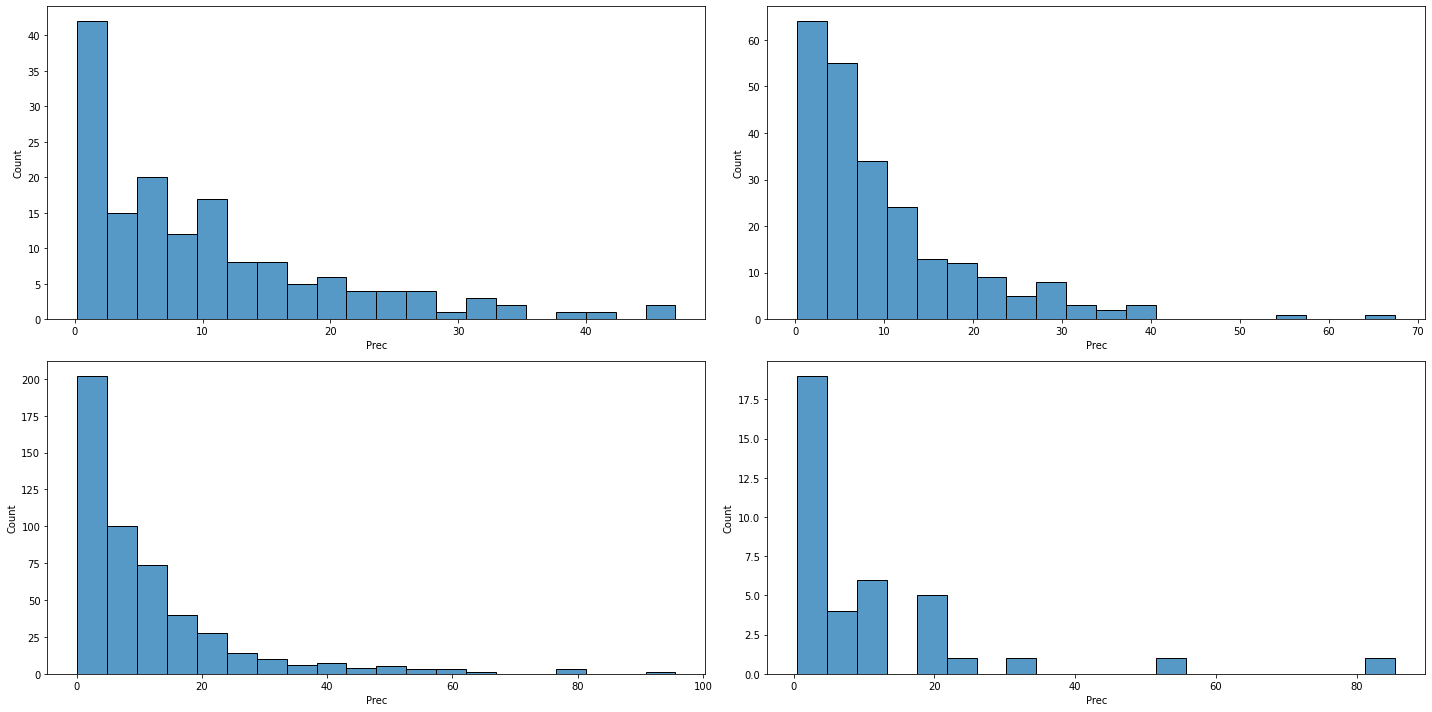

In [782]:
seasons = df_station['season'].unique()

fig, axes = plt.subplots(2,2,figsize=(20,10))
for m, ax in enumerate(axes.flatten()):
    df2 = df_station[df_station['season']==seasons[m]]
    df2 = df2[df2['Prec']!=0]
    if len(df2)>0:
        #sns.ecdfplot(data=df2, x="Prec", hue='year', ax=ax)
        sns.histplot(data=df2, x="Prec", ax=ax, bins=20)
        #ax.ylim(0.6,1)
        #ax.hist(x, bins=100, cumulative=True, density=True, histtype='step')
        #plt.xlim(0,data['Prec'].max())

plt.tight_layout()        
plt.show()

### Autocorrelation

[]

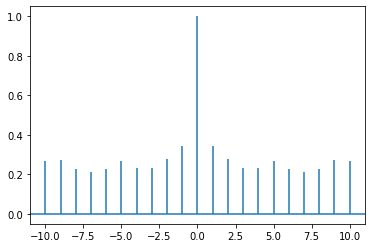

In [1174]:
x = st[st['Station'] == 'Pandoh']['Prec']
plt.acorr(x)
plt.plot()

[]

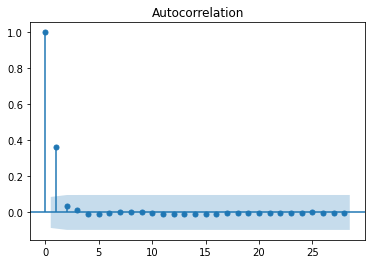

In [257]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import statsmodels
plot_acf(x)
plt.plot()

In [396]:
def acv(st, series):
    
    stations = st['Station'].unique()
    for index, station in enumerate(stations):
        x = st[st['Station']==station][series]
        acv_station = statsmodels.tsa.stattools.acf(x, nlags=30, fft=False)
        acv_station = np.expand_dims(acv_station, axis=1)

        if index == 0:
            acv = acv_station
        else:
            acv = np.concatenate([acv, acv_station],axis=1)

    #     acv_mean = acv.mean(axis=0)
    #     acv_var = acv.var(axis=0)

    return np.transpose(acv)

In [397]:
series_list = ['Prec','wrf_prcp','bias']
dfs=pd.DataFrame()
for series in series_list:  
    x = acv(st, series)
    df = pd.DataFrame(x).melt(var_name='lag')
    df['series']=series
    dfs = dfs.append(df)

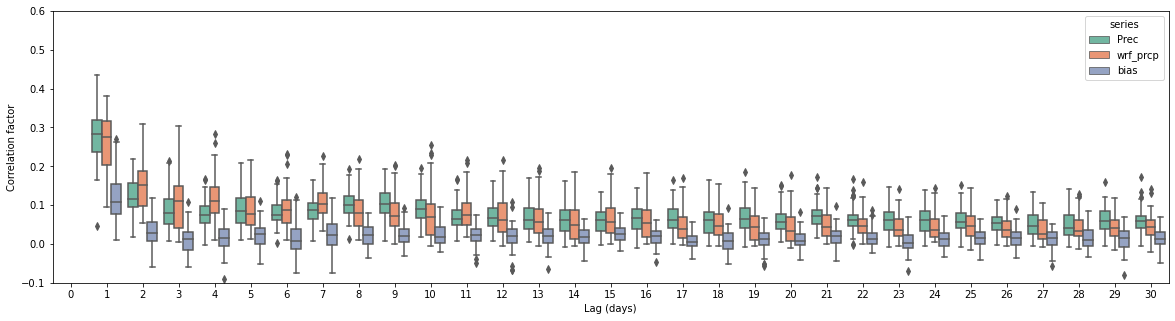

In [398]:
plt.subplots(figsize=(20,5))
sns.boxplot(data=dfs, x='lag',y='value',hue='series',palette="Set2")
plt.ylim([-0.1,0.6])
plt.ylabel('Correlation factor')
plt.xlabel('Lag (days)')

plt.show()

[]

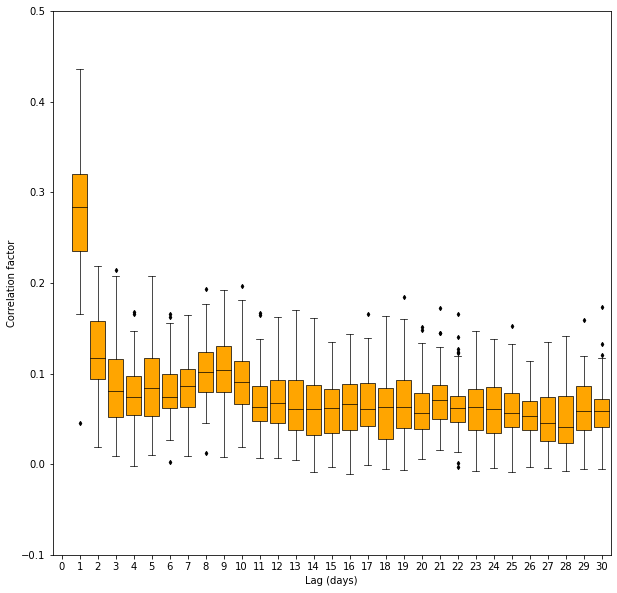

In [399]:
PROPS = {
    'boxprops':{'facecolor':'orange', 'edgecolor':'0'},
    'medianprops':{'color':'0'},
    'whiskerprops':{'color':'0'},
    'capprops':{'color':'0'},
    'flierprops':{'markerfacecolor':'0','markeredgecolor':'0'}
}

x = acv(st, series='Prec')
#y = acv(st, series='wrf_prcp')

plt.subplots(figsize=(10,10))
sns.boxplot(data=x,color='w',linewidth=0.7,fliersize=3,**PROPS)
plt.ylim([-0.1,0.5])
plt.ylabel('Correlation factor')
plt.xlabel('Lag (days)')
plt.plot()

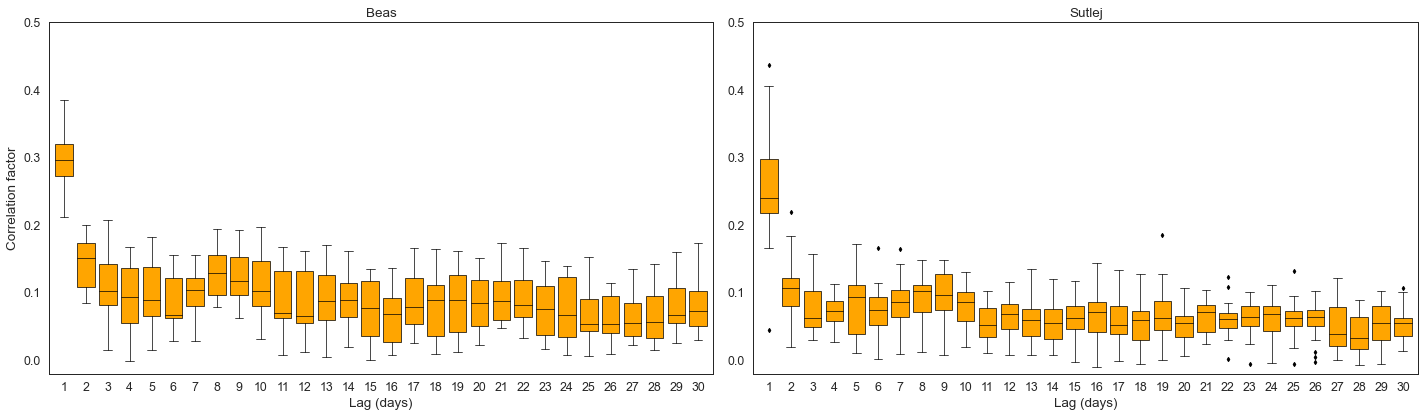

In [534]:
sns.set_theme(context='paper', style='white', font_scale=1.4)

basins = ['Beas','Sutlej']

fig, axes = plt.subplots(1,2,figsize=(20,6))

for index, ax in enumerate(axes.flatten()):
    basin = basins[index]
    st_basin = st[st['Basin']==basin]
    x = acv(st_basin, series='Prec')
    #x = x[~np.isnan(x).any(axis=1)]
    sns.boxplot(data=x,ax=ax,color='w',linewidth=0.7,fliersize=3,**PROPS)
    ax.set_ylim([-.02,0.5])
    ax.set_xlim([0.3,30.7])
    ax.set_title(basin.capitalize())
    ax.set_ylabel('Correlation factor') if index==0 else None
    ax.set_xlabel('Lag (days)')
    
plt.tight_layout()
plt.savefig('figures/autocorr-by-lag.png',dpi=300)
plt.show()

/Users/marron31/miniconda3/envs/upperindus/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


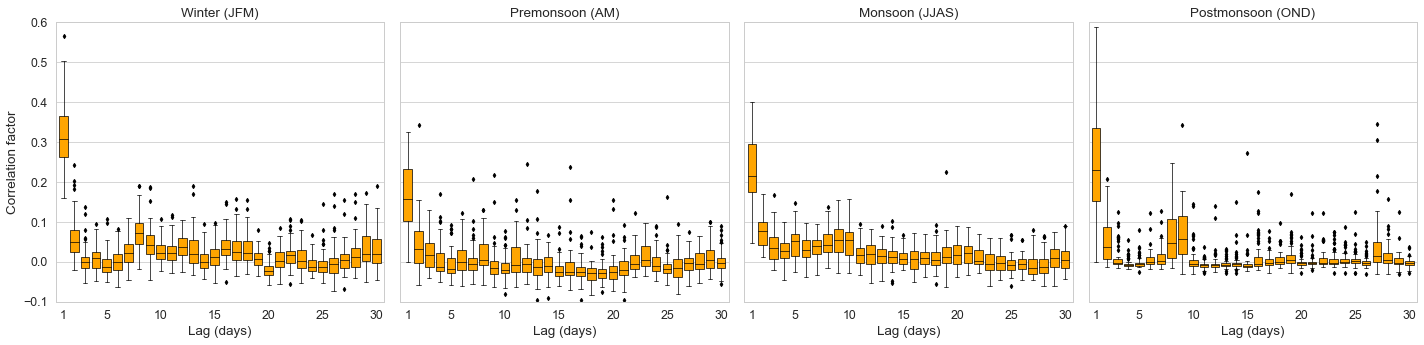

In [540]:
sns.set_theme(context='paper', style='whitegrid', font_scale=1.4)

seasons = st['season'].unique()

fig, axes = plt.subplots(1,4,figsize=(20,5))

for index, ax in enumerate(axes.flatten()):
    season = seasons[index]
    st_season = st[st['season']==season]
    x = acv(st_season, series='Prec')
    #x = x[~np.isnan(x).any(axis=1)]
    sns.boxplot(data=x,ax=ax,color='w',linewidth=0.7,fliersize=3,**PROPS)
    ax.set_ylim([-.1,0.6])
    ax.set_xlim(0.3,30.7)
    ax.set_title(season)
    ax.set_ylabel('Correlation factor') if index==0 else ax.set_ylabel('')
    ax.set_xlabel('Lag (days)')
    ax.set_yticklabels([]) if index!=0 else None
    ax.set_xticks([1,5,10,15,20,25,30])
    
plt.tight_layout()
plt.savefig('figures/autocorr-by-lag-per-season.png',dpi=300)
plt.show()

### Quantile mapping

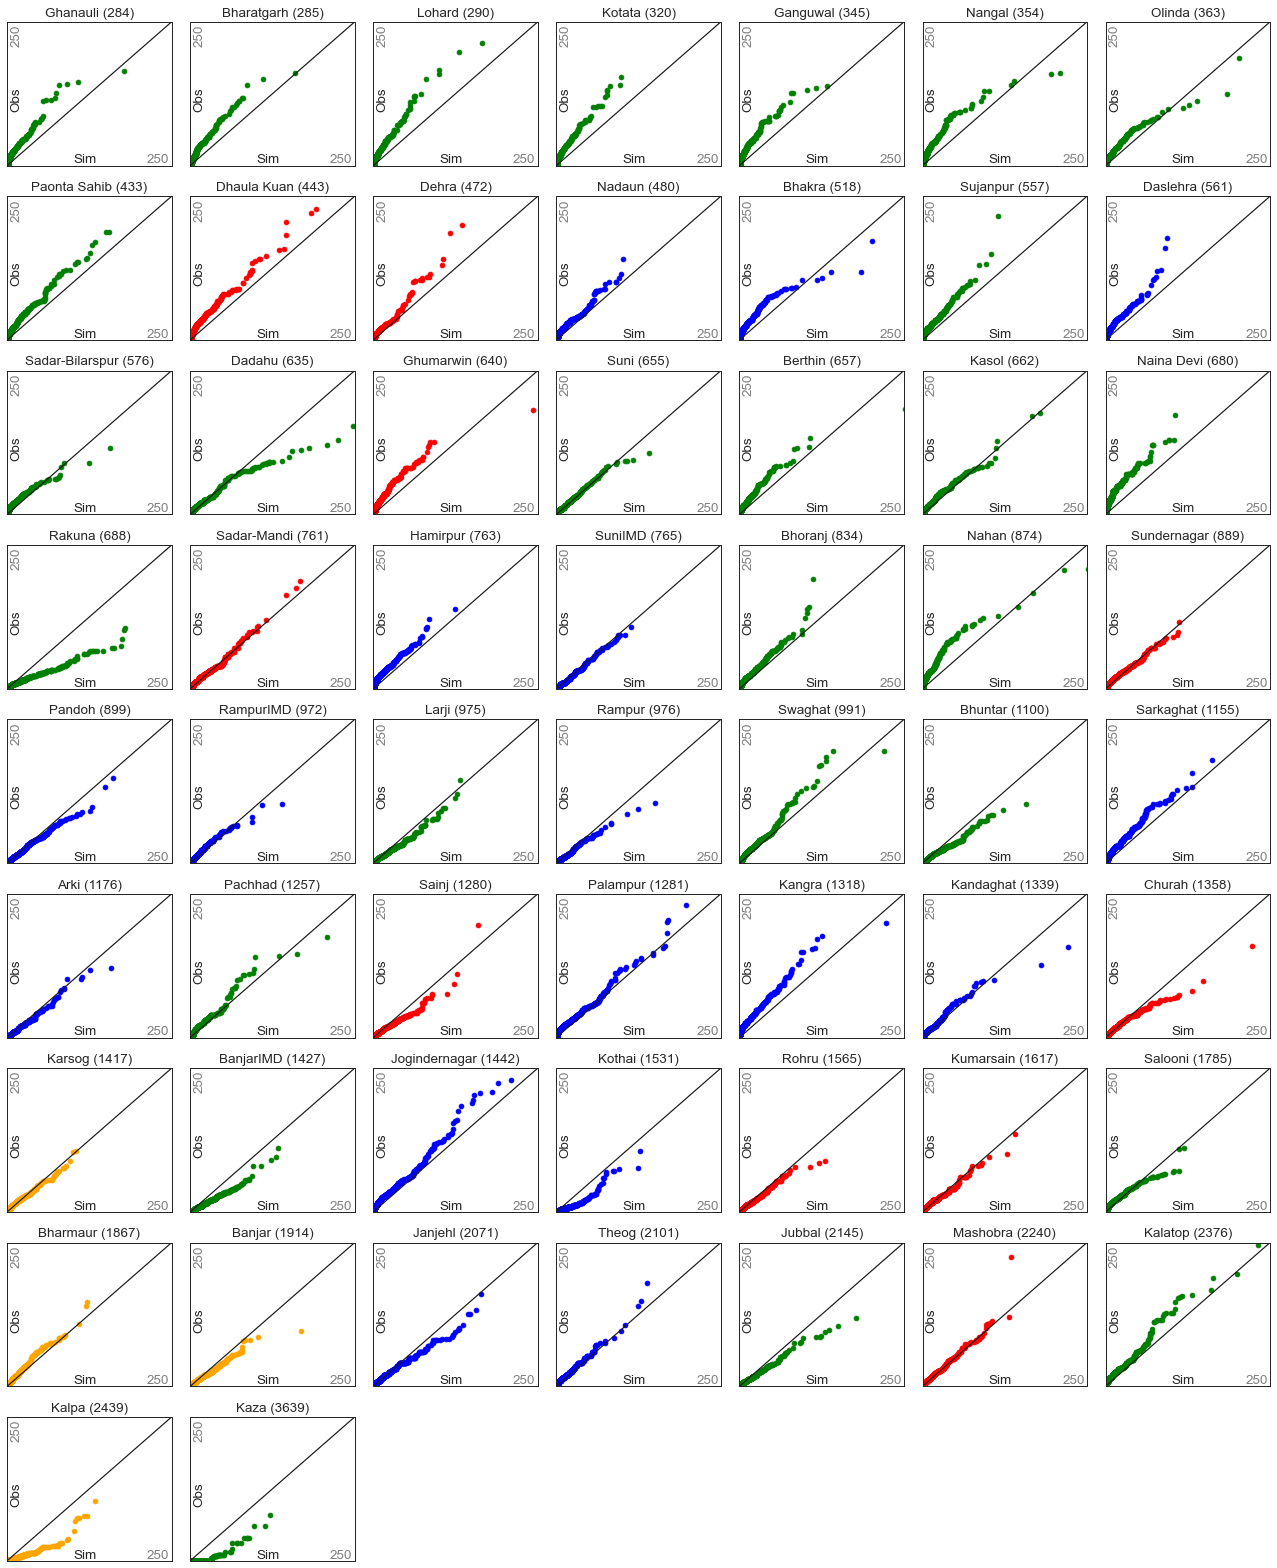

In [722]:
sns.set_theme(context='paper', style='white', font_scale=1.4)

n_rows = 9
n_cols = 7
fig, axes = plt.subplots(n_rows,n_cols,figsize=(18,22))

stations = st['Station'].unique()

sorted_stations = st.groupby(['Station']).mean().sort_values('Z').reset_index()['Station'].unique()
sorted_elevations = [int(a) for a in st.groupby(['Station']).mean().sort_values('Z').reset_index()['Z'].unique()]

sorted_labels = [f'{b} ({a})' for a,b in zip(sorted_elevations,sorted_stations)]

for index, ax in enumerate(axes.flatten()):
    
    if index>=len(sorted_stations):
        ax.axis('off')
        continue
    
    b = st[st['Station']==s]['Basin'].unique()
    
    s = sorted_stations[index] #st['Station'].unique()[np.random.randint(len(st['Station'].unique()))]

    x = st[st['Station']==s]['wrf_prcp']
    y = st[st['Station']==s]['Prec']

    qx = np.sort(x)
    qy = np.sort(y)

    if 'Beas' in b:
        ax.scatter(qx,qy,c='blue')
    elif 'Sutlej' in b:
        ax.scatter(qx,qy,c='green')
    elif 'Yamuna' in b:
        ax.scatter(qx,qy,c='red')
    else:
        ax.scatter(qx,qy,c='orange')
        
    ax.plot([0,1000],[0,1000],'k')
    ax.set_title(sorted_labels[index])# + ' in ' + b[0])
    ax.set_ylim(0,250)
    ax.set_xlim(0,250)
    
    ax.text(0.02, 0.4, "Obs", fontweight="book", transform=ax.transAxes, rotation='vertical')
    ax.text(0.4, 0.02, "Sim", fontweight="book", transform=ax.transAxes)
    
    ax.text(0.02, 0.85, "250", fontweight="ultralight", color='grey', transform=ax.transAxes, rotation='vertical')
    ax.text(0.85, 0.02, "250", fontweight="ultralight", color='grey', transform=ax.transAxes)
    
#     ax.set_yticks([]) if not(index%n_cols==0) else ax.set_yticks([0,250])
    ax.set_yticks([])
    ax.set_xticks([])
#     ax.set_ylabel('Observed (mm/day)') if index==0 else None
#     ax.set_xlabel('Simulated (mm/day)') if index==0 else None
    
plt.tight_layout()

plt.savefig('figures/qqplot-per-station.png', dpi=300)

plt.show()